In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import curl_cffi
import pandas as pd
pd.options.display.precision = 2
import sqlite3
import json
import yaml
import yfinance as yf
import datetime
from market_report_utils import (
        MarketPerformanceAnalyzer,
        apply_df_style,
        plot_vix_and_high_yield_spread,
        plot_vix_and_uncertainty_index
    )
from fred_database_utils import (
        store_fred_database,
        get_fred_ids_from_file,
        load_data_from_database,
        delete_table_from_db  # type: ignore
    )
from us_treasury import (
        plot_us_interest_rates_and_spread_3,
        plot_us_corporate_bond_spreads  # type: ignore
    )
from path_base_bootstrap import (
        run_portfolio_bootstrap,
        print_bootstrap_stats,
        run_multiple_bootstrap_simulations
    )
from pathlib import Path
from fredapi import Fred

ROOT_DIR = Path().cwd().parent
DATA_DIR = ROOT_DIR / "data"
FRED_DIR = DATA_DIR / "FRED"

db_path = FRED_DIR / "FRED.db"
id_list = get_fred_ids_from_file(file_path=FRED_DIR / "fred_series.json")

# store_fred_database(db_path=db_path, series_id_list=id_list)




In [ ]:
analyzer = MarketPerformanceAnalyzer()
sector_map_en = {
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLV": "Health Care",
    "XLI": "Industrials",
    "XLK": "Information Technology",
    "XLB": "Materials",
    "XLU": "Utilities",
    "XLC": "Communication Services",
    "XLRE": "Real Estate",
}
tickers_to_download = ["^SPX", "GLD"] + list(sector_map_en.keys())

df_price = analyzer.yf_download_with_curl(
    tickers_to_download=tickers_to_download, period="20y"
)
# display(df_price)

df = df_price.copy()
df = df.loc[df["variable"] == "Adj Close"].assign(
    value=lambda x: x["value"].astype(float)
)
df = (
    pd.pivot(
        df,
        index="Date",
        columns="Ticker",
        values="value",
    )
    .rename(columns=sector_map_en)
    .dropna(axis=1, how="any")
)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

display(df)


[*********************100%***********************]  34 of 34 completed
[*********************100%***********************]  13 of 13 completed


Ticker,GLD,Materials,Energy,Financials,Industrials,Information Technology,Consumer Staples,Utilities,Health Care,Consumer Discretionary,^SPX
Date,,,,,,,,,,,
2005-10-31,46.40,17.74,27.38,16.56,20.17,15.69,13.71,15.72,21.59,24.70,1207.01
2005-11-01,45.73,17.80,27.55,16.50,20.11,15.66,13.64,15.41,21.53,24.71,1202.76
2005-11-02,46.13,18.01,28.09,16.64,20.31,15.84,13.67,15.47,21.53,25.15,1214.76
2005-11-03,45.96,17.95,28.62,16.65,20.40,15.98,13.72,15.46,21.66,25.16,1219.94
2005-11-04,45.51,17.92,27.76,16.68,20.42,16.05,13.72,15.44,21.77,25.25,1220.14
...,...,...,...,...,...,...,...,...,...,...,...
2025-10-23,378.79,89.38,88.97,52.54,154.78,289.09,79.35,90.33,146.04,238.37,6738.44
2025-10-24,377.52,89.01,88.07,53.11,154.91,293.58,79.09,91.39,146.03,237.66,6791.69
2025-10-27,367.01,88.97,88.28,53.33,155.79,299.00,79.22,91.64,146.37,241.08,6875.16


In [ ]:
PRJ_DIR = ROOT_DIR / "SP500_Sector_Weight"
PRJ_DIR.mkdir(parents=True, exist_ok=True)
output_path = PRJ_DIR / "bootstrap_results.csv"
run_multiple_bootstrap_simulations(
    prices_df=df, output_path=output_path, max_workers=20, weight_step=0.2
)


Generating weight combinations...
Total 3003 weight combinations to simulate.
Submitting simulation tasks to executor...


Simulating weight combinations: 100%|██████████| 3003/3003 [04:10<00:00, 11.98it/s]


All simulations completed.
Results saved to c:\Users\Yuki Hata\Desktop\papers\Quants\SP500_Sector_Weight\bootstrap_results.csv


,GLD,Materials,Energy,Financials,Industrials,Information Technology,Consumer Staples,Utilities,Health Care,Consumer Discretionary,...,median_2y_return,return_5th_percentile (VaR),return_95th_percentile,mean_mdd,worst_mdd (min),mdd_5th_percentile,annualized_return (mean of paths),annualized_volatility (mean of paths),sharpe_ratio (mean of paths),sharpe_ratio (median of paths)
0,0.8,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.16,-0.09,0.59,-0.17,-0.33,-0.31,0.09,0.14,0.63,0.58
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.17,-0.24,0.65,-0.20,-0.37,-0.34,0.09,0.17,0.54,0.59
2,0.8,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,0.19,-0.12,0.61,-0.16,-0.27,-0.27,0.10,0.14,0.66,0.66
3,0.8,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,...,0.20,-0.12,0.66,-0.16,-0.30,-0.30,0.11,0.14,0.74,0.69
4,0.6,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.12,-0.05,0.57,-0.17,-0.36,-0.34,0.09,0.15,0.62,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,...,0.28,-0.27,0.64,-0.23,-0.58,-0.53,0.11,0.20,0.76,0.80
2999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,...,0.23,-0.28,0.56,-0.23,-0.57,-0.54,0.10,0.19,0.70,0.71
3000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,...,0.29,-0.34,0.74,-0.25,-0.58,-0.57,0.11,0.21,0.73,0.81
3001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.21,-0.27,0.52,-0.21,-0.57,-0.53,0.10,0.18,0.71,0.65


Index(['GLD', 'Materials', 'Energy', 'Financials', 'Industrials',
       'Information Technology', 'Consumer Staples', 'Utilities',
       'Health Care', 'Consumer Discretionary', '^SPX',
       'simulation_period_years', 'n_simulations', 'mean_2y_return',
       'variance_2y_return', 'std_dev_2y_return', 'median_2y_return',
       'return_5th_percentile (VaR)', 'return_95th_percentile', 'mean_mdd',
       'worst_mdd (min)', 'mdd_5th_percentile',
       'annualized_return (mean of paths)',
       'annualized_volatility (mean of paths)', 'sharpe_ratio (mean of paths)',
       'sharpe_ratio (median of paths)'],
      dtype='object')

,GLD,Materials,Energy,Financials,Industrials,Information Technology,Consumer Staples,Utilities,Health Care,Consumer Discretionary,...,median_2y_return,return_5th_percentile (VaR),return_95th_percentile,mean_mdd,worst_mdd (min),mdd_5th_percentile,annualized_return (mean of paths),annualized_volatility (mean of paths),sharpe_ratio (mean of paths),sharpe_ratio (median of paths)
881,0.2,0.0,0.0,0.0,0.0,0.4,0.2,0.0,0.2,0.0,...,0.28,-4.07e-02,0.57,-0.15,-0.34,-0.33,0.13,0.14,1.00,1.04
906,0.2,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.4,0.0,...,0.27,-1.22e-02,0.48,-0.13,-0.31,-0.30,0.12,0.13,1.00,1.04
880,0.2,0.0,0.0,0.0,0.0,0.4,0.4,0.0,0.0,0.0,...,0.26,-1.67e-02,0.57,-0.14,-0.33,-0.32,0.12,0.14,0.99,1.05
246,0.4,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.2,...,0.24,1.06e-02,0.60,-0.14,-0.33,-0.31,0.12,0.13,0.99,1.05
891,0.2,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.4,0.0,...,0.30,3.88e-03,0.59,-0.15,-0.36,-0.34,0.13,0.15,0.99,1.01


,GLD,Materials,Energy,Financials,Industrials,Information Technology,Consumer Staples,Utilities,Health Care,Consumer Discretionary,^SPX,sharpe_ratio (mean of paths)
881,0.2,0.0,0.0,0.0,0.0,0.4,0.2,0.0,0.2,0.0,0.0,1.00
906,0.2,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.4,0.0,0.0,1.00
880,0.2,0.0,0.0,0.0,0.0,0.4,0.4,0.0,0.0,0.0,0.0,0.99
246,0.4,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.2,0.0,0.99
891,0.2,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.4,0.0,0.0,0.99


Optimal Weights:
  GLD: 0.20
  Materials: 0.00
  Energy: 0.00
  Financials: 0.00
  Industrials: 0.00
  Information Technology: 0.40
  Consumer Staples: 0.20
  Utilities: 0.00
  Health Care: 0.20
  Consumer Discretionary: 0.00
  ^SPX: 0.00
--- Simulation Statistics (2-Year Horizon) ---
simulation_period_years                 :          2
n_simulations                           :       5000
mean_2y_return                          :     27.25%
variance_2y_return                      :      2.92%
std_dev_2y_return                       :     17.08%
median_2y_return                        :     27.51%
return_5th_percentile (VaR)             :     -3.77%
return_95th_percentile                  :     56.62%
mean_mdd                                :    -14.77%
worst_mdd (min)                         :    -34.39%
mdd_5th_percentile                      :    -33.34%
annualized_return (mean of paths)       :     12.54%
annualized_volatility (mean of paths)   :     13.90%
sharpe_ratio (mean of pat

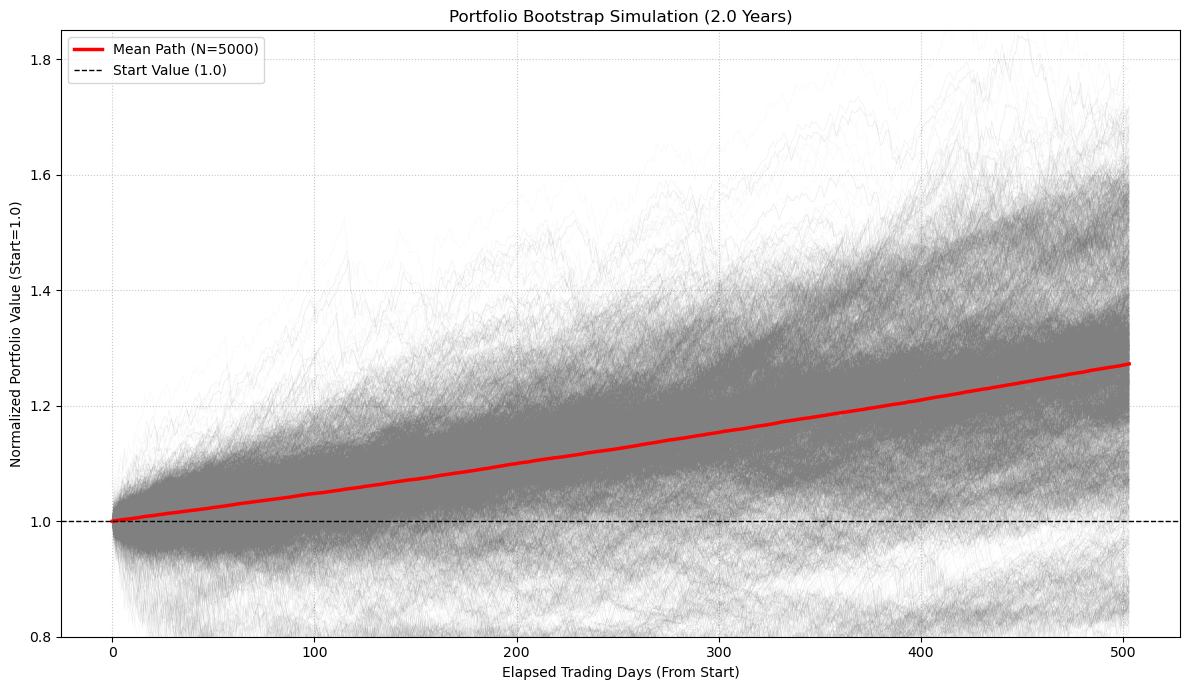

In [ ]:
sort_cols = ["sharpe_ratio (mean of paths)"]
# sort_cols = ["mean_2y_return"]
df_result = pd.read_csv(output_path).sort_values(sort_cols, ascending=False)
display(df_result.columns)
display(df_result.head(5))
df_result = df_result[df.columns.tolist() + sort_cols]
display(df_result.head(5))

optimal_weights = df_result.iloc[0][df.columns.tolist()].to_dict()
print("Optimal Weights:")
for k, v in optimal_weights.items():
    print(f"  {k}: {v:.2f}")

# weights = {
#     "Information Technology": 0.4,
#     "GLD": 0.2,
#     "Utilities": 0.2,
#     "Consumer Discretionary": 0.2,
# }
weights = optimal_weights

stats, fig = run_portfolio_bootstrap(prices_df=df, weights=weights)

print_bootstrap_stats(stats)
plt.tight_layout()
plt.show()
